In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statistics
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA

## preprocessing : train set (2016~2019년도 팀타자 기록)

In [ ]:
# 팀타자
team_hitter_16 = pd.read_csv('2020빅콘테스트_스포츠투아이_제공데이터_팀타자_2016.csv')
team_hitter_17 = pd.read_csv('2020빅콘테스트_스포츠투아이_제공데이터_팀타자_2017.csv')
team_hitter_18 = pd.read_csv('2020빅콘테스트_스포츠투아이_제공데이터_팀타자_2018.csv')
team_hitter_19 = pd.read_csv('2020빅콘테스트_스포츠투아이_제공데이터_팀타자_2019.csv')
team_hitter_20 = pd.read_csv('2020빅콘테스트_스포츠투아이_제공데이터_팀타자_2020.csv')

# 경기
game_16 = pd.read_csv('2020빅콘테스트_스포츠투아이_제공데이터_경기_2016.csv', encoding="CP949")
game_17 = pd.read_csv('2020빅콘테스트_스포츠투아이_제공데이터_경기_2017.csv', encoding="CP949")
game_18 = pd.read_csv('2020빅콘테스트_스포츠투아이_제공데이터_경기_2018.csv', encoding="CP949")
game_19 = pd.read_csv('2020빅콘테스트_스포츠투아이_제공데이터_경기_2019.csv', encoding="CP949")
game_20 = pd.read_csv('2020빅콘테스트_스포츠투아이_제공데이터_경기_2020.csv', encoding="CP949")

In [ ]:
# 일정 별 몇 번째 경기인지 표시하는 함수
def game_from_date_to_game(data_set) :
    cnt = np.zeros((len(data_set),10), dtype='i8')
    
    team=["HH","HT","KT","LG","LT","NC","OB","SK","SS","WO"]
    for i in range(len(data_set)):
        col=0
        for j in team:
            if data_set.values[i,2]==j or data_set.values[i,3]==j:
                cnt[i,col]=np.count_nonzero(cnt[:i,col])+1
            col+=1

    return_data_set = pd.concat([data_set, pd.DataFrame(cnt.reshape(len(cnt),10),columns=team)],axis=1)
    
    return_data_set = return_data_set.groupby('G_ID').sum().iloc[:, 1:]
    
    return return_data_set

#일별로 팀의 경기수만 표시
date_game_16=game_from_date_to_game(game_16)
date_game_17=game_from_date_to_game(game_17)
date_game_18=game_from_date_to_game(game_18)
date_game_19=game_from_date_to_game(game_19)

In [ ]:
# 경기별 기록에 몇번째 경기인지 나타내는 변수를 추가하는 함수
def merge_date_game(date_game, data_set):
    HH_date_game=date_game.loc[date_game.HH>0,:].reset_index().loc[:,['G_ID','HH']]
    result=pd.merge(data_set.loc[data_set.T_ID=='HH',:], HH_date_game, on='G_ID')
    result.rename(columns={'HH': 'game'}, inplace=True)
    
    team=["HT","KT","LG","LT","NC","OB","SK","SS","WO"]
    for i in team:
        team_date_game=date_game.loc[date_game.loc[:,i]>0,:].reset_index().loc[:,['G_ID', i]]
        team_data=pd.merge(data_set.loc[data_set.T_ID==i,:], team_date_game, on='G_ID')
        team_data.rename(columns={i: 'game'}, inplace=True)
        result=pd.concat([result, team_data])
        
    return result

#위 함수로 변수 추가
hitter_game_16=merge_date_game(date_game_16, team_hitter_16)
hitter_game_17=merge_date_game(date_game_17, team_hitter_17)
hitter_game_18=merge_date_game(date_game_18, team_hitter_18)
hitter_game_19=merge_date_game(date_game_19, team_hitter_19)

# 위 데이터로 115경기까지의 기록만 남기기
def transform_data_until_n(data, n):
    data_until_n = data.loc[data.game<=n,:]
    transform_until_n=data_until_n.groupby(['T_ID','TB_SC']).sum().iloc[:,2:21]
    
    return transform_until_n
    
team_hitter_16_until_n=transform_data_until_n(hitter_game_16, 115)
team_hitter_17_until_n=transform_data_until_n(hitter_game_17, 115)
team_hitter_18_until_n=transform_data_until_n(hitter_game_18, 115)
team_hitter_19_until_n=transform_data_until_n(hitter_game_19, 115)

# 모든 연도별 데이터를 하나로 합치기
team_hitter_until_n=pd.concat([team_hitter_16_until_n,team_hitter_17_until_n,team_hitter_18_until_n,team_hitter_19_until_n])

In [ ]:
# 타자 지표 계산 함수
def calculate(data):
    data=data.drop(['ERR', 'LOB'], axis=1)
    H1=data.HIT-data.H2-data.H3-data.HR
    data['H1']=H1
    data['AVG']=data.HIT/data.AB
    opb=(data.HIT+data.BB+data.IB+data.HP)/(data.AB+data.BB+data.IB+data.HP+data.SF)
    slg=(data.H1+2*data.H2+3*data.H3+4*data.HR)/data.AB
    data['OPS']=opb+slg
    tb=data.H1+2*data.H2+3*data.H3+4*data.HR
    data['CQ']=(0.5*data.HIT+0.3*tb)/(data.AB-data.KK)
    data['BABIP']=(data.HIT-data.HR)/(data.AB-data.KK-data.HR+data.SF)
    data['BK']=(data.BB)/(data.KK)
    
    return data

train_x = calculate(team_hitter_until_n).reset_index()

# home - away 경기로 나누기
home_train_x = train_x.loc[train_x.TB_SC=='B',:]
away_train_x = train_x.loc[train_x.TB_SC=='T',:]

# index 생성
home_train_x.index = home_train_x.T_ID
home_train_x = home_train_x.drop(['T_ID', 'TB_SC'], axis=1)

away_train_x.index = away_train_x.T_ID
away_train_x = away_train_x.drop(['T_ID', 'TB_SC'], axis=1)

# '연도+팀이름'으로 index 수정
train_index = ('16'+home_train_x.index[0:10]).values.tolist()+('17'+home_train_x.index[10:20]).values.tolist()+('18'+home_train_x.index[20:30]).values.tolist()+('19'+home_train_x.index[30:40]).values.tolist()
home_train_x.index = train_index
away_train_x.index = train_index

In [ ]:
# home & away간 경기 편차를 반영하기 위한 home-away 변수
home_train_x['diff_PA'] = home_train_x.PA - away_train_x.PA
home_train_x['diff_AB'] = home_train_x.AB - away_train_x.AB
home_train_x['diff_HIT'] = home_train_x.HIT - away_train_x.HIT

away_train_x['diff_PA'] = away_train_x.PA - home_train_x.PA
away_train_x['diff_AB'] = away_train_x.AB - home_train_x.AB
away_train_x['diff_HIT'] = away_train_x.HIT - home_train_x.HIT

## preprocessing : test set (2020년 팀타자 기록 from STATIZ)

In [ ]:
# load test data
home_test_x = pd.read_csv('hitter_home_test_x.csv')
away_test_x = pd.read_csv('hitter_away_test_x.csv')

home_test_x = calculate(home_test_x)
away_test_x = calculate(away_test_x)

home_test_x.index = home_test_x['Unnamed: 0']
home_test_x = home_test_x.drop('Unnamed: 0', axis=1)

away_test_x.index = away_test_x['Unnamed: 0']
away_test_x = away_test_x.drop('Unnamed: 0', axis=1)

In [ ]:
# home & away간 경기 편차를 반영하기 위한 home-away 변수
home_test_x['diff_PA'] = home_test_x.PA - away_test_x.PA
home_test_x['diff_AB'] = home_test_x.AB - away_test_x.AB
home_test_x['diff_HIT'] = home_test_x.HIT - away_test_x.HIT

away_test_x['diff_PA'] = away_test_x.PA - home_test_x.PA
away_test_x['diff_AB'] = away_test_x.AB - home_test_x.AB
away_test_x['diff_HIT'] = away_test_x.HIT - home_test_x.HIT

In [ ]:
# scaling 이전 train과 test set의 열 순서 맞추기
home_test_x = home_test_x[home_train_x.columns]
away_test_x = away_test_x[away_train_x.columns]

## Scaling independent varaible

In [ ]:
# 독립변수 scaling
def scaling(data):
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)
    dataframe_scaled = pd.DataFrame(data_scaled, index=data.index, columns=data.columns)
    
    return dataframe_scaled, scaler

home_train_x_scaled, home_scaler = scaling(home_train_x)
home_test_x_scaled = pd.DataFrame(home_scaler.transform(home_test_x), index=home_test_x.index, columns=home_test_x.columns) 

away_train_x_scaled, away_scaler = scaling(away_train_x)
away_test_x_scaled = pd.DataFrame(away_scaler.transform(away_test_x), index=away_test_x.index, columns=away_test_x.columns)

## preprocessing : train set - dependent variable

In [ ]:
# y값으로 사용할 팀별 n경기 이후의 안타율 계산
def avg_over_n(n, hitter_game):
    data_over_n=hitter_game.loc[hitter_game.game>n, :]
    data_over_n=data_over_n.groupby(['T_ID','TB_SC']).sum().loc[:,['AB','HIT']]
    data_over_n['AVG']=data_over_n.HIT/data_over_n.AB
    data_over_n=data_over_n.drop(['AB','HIT'],axis=1)
   
    return data_over_n

# y : 115경기 이후의 팀안타율
avg_16_over115=avg_over_n(115, hitter_game_16)
avg_17_over115=avg_over_n(115, hitter_game_17)
avg_18_over115=avg_over_n(115, hitter_game_18)
avg_19_over115=avg_over_n(115, hitter_game_19)

# 모든 연도별 데이터를 하나로 합치기
train_y = pd.concat([avg_16_over115,avg_17_over115,avg_18_over115,avg_19_over115])
train_y = train_y.reset_index()

# home - away 경기로 나누기
home_train_y=train_y.loc[train_y.TB_SC=='B',:]
away_train_y=train_y.loc[train_y.TB_SC=='T',:]

# train set과 동일한 index 생성
home_train_y.index = train_index
away_train_y.index = train_index

# index 생성 이후 필요없는 변수 제거
home_train_y=home_train_y.drop(['T_ID', 'TB_SC'], axis=1)
away_train_y=away_train_y.drop(['T_ID', 'TB_SC'], axis=1)

## Modeling

In [ ]:
# Ordinary Least Sqaure regression
def ols(train_x, train_y, test_x, test_y):
    linreg = LinearRegression(n_jobs=-1)
    linreg_fit = linreg.fit(train_x, train_y)
    pred = linreg.predict(test_x)
    
    r_squared = linreg.score(train_x, train_y)
    rmse = np.sqrt(np.mean((pred-test_y).values**2))
    
    return pred, r_squared, rmse, linreg

ols_home_pred_y, ols_home_r_squared, ols_home_rmse, home_linreg = ols(home_train_x_scaled, home_train_y, home_train_x_scaled, home_train_y)
ols_away_pred_y, ols_away_r_squared, ols_away_rmse, away_linreg = ols(away_train_x_scaled, away_train_y, away_train_x_scaled, away_train_y)

In [ ]:
# OLS result
print('R squared :', ols_home_r_squared)
print('RMSE :', ols_home_rmse)

print('R squared :', ols_away_r_squared)
print('RMSE :', ols_away_rmse)

R squared : 0.7342477574708065
RMSE : 0.014058657338072739
R squared : 0.6517764971064341
RMSE : 0.014931415272512417


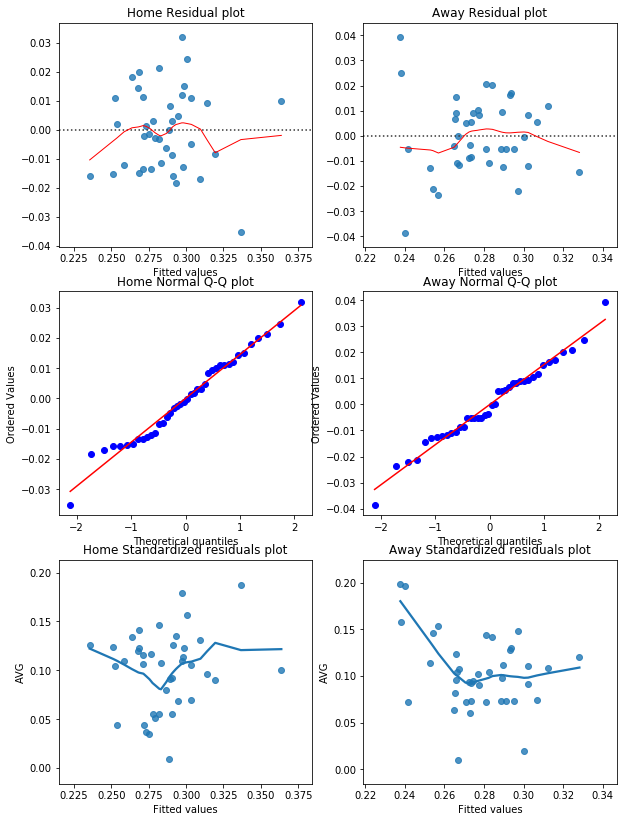

In [ ]:
# OLS residual analysis
def plot_nor_assump(home_pred_y, home_y, away_pred_y, away_y):
    plt.figure(figsize=(10,14))
    
    plt.subplot(3,2,1)
    sns.residplot(home_pred_y.reshape(-1), home_y.values.reshape(-1), lowess=True, line_kws={'color':'red','lw':1,'alpha':1})
    plt.xlabel('Fitted values')
    plt.title('Home Residual plot')

    plt.subplot(3,2,2)
    sns.residplot(away_pred_y.reshape(-1), away_y.values.reshape(-1), lowess=True, line_kws={'color':'red','lw':1,'alpha':1})
    plt.xlabel('Fitted values')
    plt.title('Away Residual plot')
    
    home_residual = home_y.iloc[:,0] - home_pred_y.reshape(-1)
    away_residual = away_y.iloc[:,0] - away_pred_y.reshape(-1)

    plt.subplot(3,2,3)
    stats.probplot(home_residual, dist='norm', plot=plt)
    plt.title('Home Normal Q-Q plot')

    plt.subplot(3,2,4)
    stats.probplot(away_residual, dist='norm', plot=plt)
    plt.title('Away Normal Q-Q plot')

    home_standardized_residual = np.sqrt(np.abs(home_residual))
    away_standardized_residual = np.sqrt(np.abs(away_residual))

    plt.subplot(3,2,5)
    sns.regplot(home_pred_y.reshape(-1), home_standardized_residual, scatter=True, lowess=True)
    plt.xlabel('Fitted values')
    plt.title('Home Standardized residuals plot')

    plt.subplot(3,2,6)
    sns.regplot(away_pred_y.reshape(-1), away_standardized_residual, scatter=True, lowess=True)
    plt.xlabel('Fitted values')
    plt.title('Away Standardized residuals plot')
    
    plt.show()
    
plot_nor_assump(ols_home_pred_y, home_train_y, ols_away_pred_y, away_train_y)

In [ ]:
# 유의하지 않은 변수를 제거하기 위해 coefficient 확인
# 표준화된 변수로 modeling을 했기 때문에 각 coefficient = t test statistic
home_coef_table = pd.DataFrame({'variable' : home_train_x_scaled.columns, 'coef': np.abs(home_linreg.coef_.reshape(-1))}).sort_values('coef')
home_coef_table

,variable,coef
9,CS,0.000149
13,IB,0.001735
3,RUN,0.002037
6,H3,0.003204
16,GD,0.005874
12,BB,0.008910
8,SB,0.008918
11,SF,0.008991
14,HP,0.018076
25,diff_HIT,0.020462


In [ ]:
# 유의하지 않은 변수를 제거하기 위해 coefficient 확인
# 표준화된 변수로 modeling을 했기 때문에 각 coefficient = t test statistic
away_coef_table = pd.DataFrame({'variable' : away_train_x_scaled.columns, 'coef': np.abs(away_linreg.coef_.reshape(-1))}).sort_values('coef')
away_coef_table

,variable,coef
13,IB,0.001535
25,diff_HIT,0.004765
6,H3,0.005478
16,GD,0.005514
9,CS,0.005520
17,H1,0.006235
8,SB,0.009170
5,H2,0.014245
18,AVG,0.020268
4,HIT,0.022757


In [ ]:
# coef 값이 0.01보다 작은 변수 제거
def remove_var(coef_table, x, alpha):
    remove_coef = coef_table.loc[coef_table.coef<alpha,:].index
    remain_var = coef_table.drop(remove_coef).variable
    
    removed_x = x.loc[:, remain_var]
    
    return removed_x

home_train_x_scaled = remove_var(home_coef_table, home_train_x_scaled, 0.01)
away_train_x_scaled = remove_var(away_coef_table, away_train_x_scaled, 0.01)

home_test_x_scaled = remove_var(home_coef_table, home_test_x_scaled, 0.01)
away_test_x_scaled = remove_var(away_coef_table, away_test_x_scaled, 0.01)

In [ ]:
# vif 확인

#home
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(home_train_x_scaled.values, i) for i in range(home_train_x_scaled.shape[1])]
vif["features"] = home_train_x_scaled.columns
vif

,VIF Factor,features
0,16.259957,HP
1,22.004665,diff_HIT
2,280.430387,diff_AB
3,10.994003,SH
4,1278.950414,KK
5,26.400463,RBI
6,166.779687,diff_PA
7,110.303123,H2
8,171.646242,BK
9,2347.116131,HIT


In [ ]:
#away
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(away_train_x_scaled.values, i) for i in range(away_train_x_scaled.shape[1])]
vif["features"] = away_train_x_scaled.columns
vif

# 다중공선성 다수 식별

,VIF Factor,features
0,8.122855,H2
1,2434.566840,AVG
2,3443.268894,HIT
3,1980.836164,BABIP
4,123.414116,RBI
5,2729.514221,CQ
6,142.771013,diff_AB
7,135.137234,RUN
8,715.239519,KK
9,154.750718,diff_PA


In [ ]:
# pca로 다중공선성 해결

def pca(train_x, n):
    pca = PCA(n_components=n)
    train_x_pca = pca.fit_transform(train_x)
    
    return train_x_pca 

In [ ]:
# sample weight 부여하는 함수
def wls(train_x, train_y, test_x, test_y, weight):
    linreg = LinearRegression(n_jobs=-1)
    linreg_fit = linreg.fit(train_x, train_y, sample_weight=weight)
    pred = linreg.predict(test_x)
    
    r_squared = linreg.score(train_x, train_y, sample_weight=weight)
    rmse = np.sqrt(np.mean((pred-test_y).values**2))
    
    return pred, r_squared, rmse, linreg 

In [ ]:
# PCA+WLS에 대해 최적의 n_component 결정 (by cross validation)
min_home_rmse = 100
min_away_rmse = 100

min_home_npca=0
min_away_npca=0

for i in range(2,10):
    home_train_x_pca = pca(home_train_x_scaled, i)
    away_train_x_pca = pca(away_train_x_scaled, i)

    ols_home_pred_y_pca, ols_home_r_squared_pca, ols_home_rmse_pca, home_linreg_pca = ols(home_train_x_pca, home_train_y, home_train_x_pca, home_train_y)
    ols_away_pred_y_pca, ols_away_r_squared_pca, ols_away_rmse_pca, away_linreg_pca = ols(away_train_x_pca, away_train_y, away_train_x_pca, away_train_y)
    
    residual = home_train_y.iloc[:,0] - ols_home_pred_y_pca.reshape(-1)
    resd_var = (residual**2)/(home_train_x_pca.shape[0]-home_train_x_pca.shape[1])
    home_weight = 1/resd_var

    residual = away_train_y.iloc[:,0] - ols_away_pred_y_pca.reshape(-1)
    resd_var = (residual**2)/(away_train_x_pca.shape[0]-away_train_x_pca.shape[1])
    away_weight = 1/resd_var

    wls_home_pred_y_pca, wls_home_r_squared_pca, wls_home_rmse_pca, wls_home_linreg = wls(home_train_x_pca, home_train_y, home_train_x_pca, home_train_y, home_weight)
    wls_away_pred_y_pca, wls_away_r_squared_pca, wls_away_rmse_pca, wls_away_linreg = wls(away_train_x_pca, away_train_y, away_train_x_pca, away_train_y, away_weight)
    
    
    lin_scores = cross_val_score(wls_home_linreg, home_train_x_pca, home_train_y, scoring="neg_mean_squared_error", cv=4)
    lin_rmse_scores = np.sqrt(-lin_scores)
    home_rmse = np.mean(lin_rmse_scores)
    
    lin_scores = cross_val_score(wls_away_linreg, away_train_x_pca, away_train_y, scoring="neg_mean_squared_error", cv=4)
    lin_rmse_scores = np.sqrt(-lin_scores)
    away_rmse = np.mean(lin_rmse_scores)
    
    if (min_home_rmse > home_rmse):
        min_home_rmse = home_rmse
        min_home_npca = i
        
    if (min_away_rmse > away_rmse):
        min_away_rmse = away_rmse
        min_away_npca = i

print('home : n_pca =', min_home_npca, '/ rmse =', min_home_rmse)
print('away : n_pca =', min_away_npca, '/ rmse =', min_away_rmse)

home : n_pca = 5 / rmse = 0.027170358322972005
away : n_pca = 2 / rmse = 0.024744364391607765


In [ ]:
# 최적의 n_component로 PCA 후 분산 설명력 확인
def final_pca(train_x, test_x, n):
    pca = PCA(n_components=n)
    train_x_pca = pca.fit_transform(train_x)
    test_x_pca = pca.transform(test_x)
    print(pca.explained_variance_ratio_.sum())
    
    return train_x_pca, test_x_pca

home_train_x_pca, home_test_x_pca = final_pca(home_train_x_scaled, home_test_x_scaled, min_home_npca)
away_train_x_pca, away_test_x_pca = final_pca(away_train_x_scaled, away_test_x_scaled, min_away_npca+1) #누적 분산이 너무 적어 +1

0.9179575721244536
0.817161088100088


In [ ]:
# PCA + WLS

ols_home_pred_y_pca, ols_home_r_squared_pca, ols_home_rmse_pca, home_linreg_pca = ols(home_train_x_pca, home_train_y, home_train_x_pca, home_train_y)
ols_away_pred_y_pca, ols_away_r_squared_pca, ols_away_rmse_pca, away_linreg_pca = ols(away_train_x_pca, away_train_y, away_train_x_pca, away_train_y)

# sample weight 부여
residual = home_train_y.iloc[:,0] - ols_home_pred_y_pca.reshape(-1)
resd_var = (residual**2)/(home_train_x_pca.shape[0]-home_train_x_pca.shape[1])
home_weight = 1/resd_var**2

residual = away_train_y.iloc[:,0] - ols_away_pred_y_pca.reshape(-1)
resd_var = (residual**2)/(away_train_x_pca.shape[0]-away_train_x_pca.shape[1])
away_weight = 1/resd_var**2

wls_home_pred_y_pca, wls_home_r_squared_pca, wls_home_rmse_pca, wls_home_linreg = wls(home_train_x_pca, home_train_y, home_train_x_pca, home_train_y, home_weight)
wls_away_pred_y_pca, wls_away_r_squared_pca, wls_away_rmse_pca, wls_away_linreg = wls(away_train_x_pca, away_train_y, away_train_x_pca, away_train_y, away_weight)

print('R squared :', wls_home_r_squared_pca)
print('RMSE :', wls_home_rmse_pca)

print('R squared :', wls_away_r_squared_pca)
print('RMSE :', wls_away_rmse_pca)

R squared : 0.9998365187212332
RMSE : 0.02301049384525551
R squared : 0.9999979726439894
RMSE : 0.02278657769709409


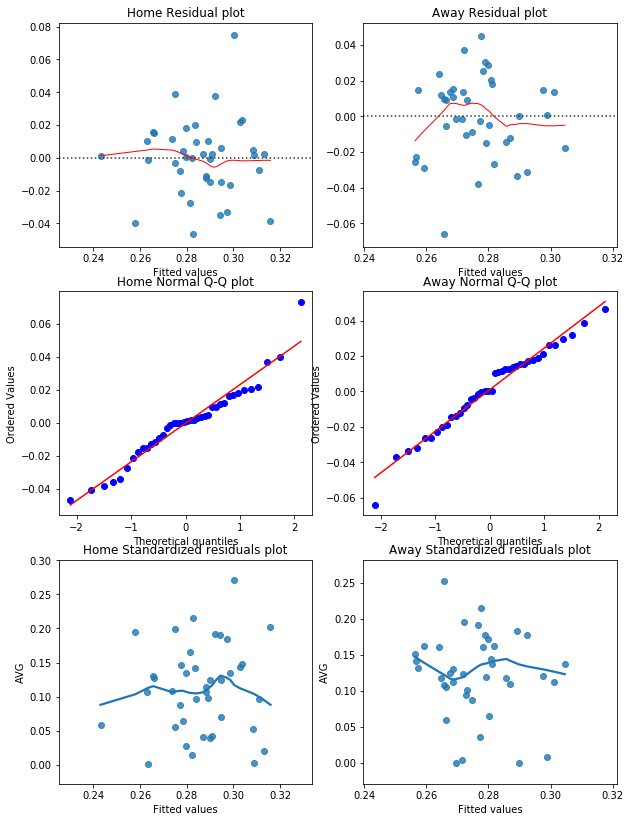

In [ ]:
# PCA + WLS model : residual analysis
plot_nor_assump(wls_home_pred_y_pca, home_train_y, wls_away_pred_y_pca, away_train_y)

In [ ]:
# 이후 iloc method를 사용하기 위해 데이터프레임화
home_train_x_pca=pd.DataFrame(home_train_x_pca, index=home_train_x.index, columns=list(range(1,min_home_npca+1)))
away_train_x_pca=pd.DataFrame(away_train_x_pca, index=away_train_x.index, columns=list(range(1,min_away_npca+2)))

In [ ]:
# outlier제외를 위한 residual 확인
home_residual = pd.DataFrame(abs((home_train_y.iloc[:,0] - wls_home_pred_y_pca.reshape(-1))))
home_outlier_n = len(home_residual.loc[np.abs(home_residual.AVG)>=0.05,:])
home_outlier = home_residual.sort_values(by='AVG',ascending=False).head(home_outlier_n).index.tolist()

away_residual = pd.DataFrame(abs((away_train_y.iloc[:,0] - wls_away_pred_y_pca.reshape(-1))))
away_outlier_n = len(away_residual.loc[np.abs(away_residual.AVG)>=0.05,:])
away_outlier = away_residual.sort_values(by='AVG',ascending=False).head(away_outlier_n).index.tolist()

In [ ]:
# 위에서 확인한 outlier 제외
home_train_x_pca=home_train_x_pca.drop(home_outlier)
home_train_y=home_train_y.drop(home_outlier)

away_train_x_pca=away_train_x_pca.drop(away_outlier)
away_train_y=away_train_y.drop(away_outlier)

In [ ]:
# outlier 제거 후 다시 WLS
ols_home_pred_y_pca, ols_home_r_squared_pca, ols_home_rmse_pca, home_linreg_pca = ols(home_train_x_pca, home_train_y, home_train_x_pca, home_train_y)
ols_away_pred_y_pca, ols_away_r_squared_pca, ols_away_rmse_pca, away_linreg_pca = ols(away_train_x_pca, away_train_y, away_train_x_pca, away_train_y)

residual = home_train_y.iloc[:,0] - ols_home_pred_y_pca.reshape(-1)
resd_var = (residual**2)/(home_train_x_pca.shape[0]-home_train_x_pca.shape[1])
home_weight = 1/resd_var**2

residual = away_train_y.iloc[:,0] - ols_away_pred_y_pca.reshape(-1)
resd_var = (residual**2)/(away_train_x_pca.shape[0]-away_train_x_pca.shape[1])
away_weight = 1/resd_var**2

wls_home_pred_y_pca, wls_home_r_squared_pca, wls_home_rmse_pca, wls_home_linreg = wls(home_train_x_pca, home_train_y, home_train_x_pca, home_train_y, home_weight)
wls_away_pred_y_pca, wls_away_r_squared_pca, wls_away_rmse_pca, wls_away_linreg = wls(away_train_x_pca, away_train_y, away_train_x_pca, away_train_y, away_weight)

In [ ]:
print('R squared :', wls_home_r_squared_pca)
print('RMSE :', wls_home_rmse_pca)

print('R squared :', wls_away_r_squared_pca)
print('RMSE :', wls_away_rmse_pca)

R squared : 0.9987629803045593
RMSE : 0.019326242689255726
R squared : 0.9999956537535849
RMSE : 0.02023910356510788


## residual analysis

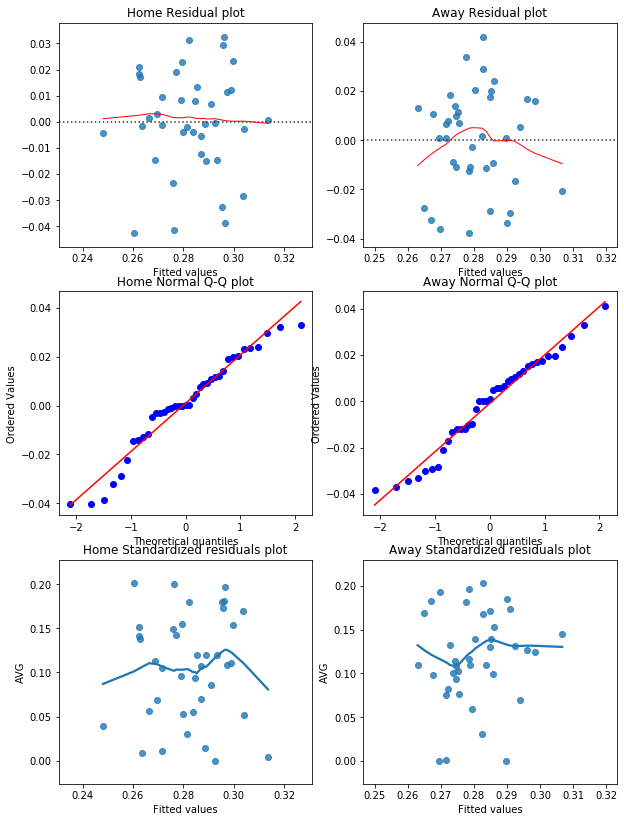

In [ ]:
# PCA + WLS + delete_outlier model : residual anaylsis
plot_nor_assump(wls_home_pred_y_pca, home_train_y, wls_away_pred_y_pca, away_train_y)

# Predict

In [ ]:
# result table
home_result = pd.DataFrame({'T_ID' : home_test_x_scaled.index, 'pred_AVG' : wls_home_linreg.predict(home_test_x_pca).reshape(-1)})
away_result = pd.DataFrame({'T_ID' : away_test_x_scaled.index, 'pred_AVG' : wls_away_linreg.predict(away_test_x_pca).reshape(-1)})

In [ ]:
# final result를 구하기 위해 잔여일정 동안의 home & away 경기수 계산
remain_match = pd.read_csv('test set.csv')

home_remain = remain_match.loc[remain_match.TB_SC=='B',:]
away_remain = remain_match.loc[remain_match.TB_SC=='T',:]

team = ["HH","HT","KT","LG","LT","NC","OB","SK","SS","WO"]
home_count = []
away_count = []

for i in range(len(team)) :
    home_count.append(len(home_remain.loc[home_remain.T_ID==team[i],:]))
    away_count.append(len(away_remain.loc[away_remain.T_ID==team[i],:]))
    
game_count = pd.DataFrame({'T_ID':pd.Series(team), 'home_count':pd.Series(home_count), 'away_count':pd.Series(away_count)})

In [ ]:
# home & away 예측값 테이블과 merge
game_count = pd.merge(game_count, home_result, on='T_ID')
game_count = pd.merge(game_count, away_result, on='T_ID')

In [ ]:
# 경기횟수에 의한 예측값 가중평균
game_count['AVG'] = ((game_count.home_count*game_count.pred_AVG_x)*(game_count.home_count/15)+(game_count.away_count*game_count.pred_AVG_y)*(game_count.away_count/15))/((game_count.home_count+game_count.away_count)*((game_count.home_count+game_count.away_count)/30))

In [ ]:
# final result
final_predict = game_count[['T_ID','AVG']]
final_predict.sort_values('AVG', ascending=False)

,T_ID,AVG
5,NC,0.293591
6,OB,0.288065
8,SS,0.283448
2,KT,0.282892
9,WO,0.281999
3,LG,0.281507
1,HT,0.279743
4,LT,0.272058
7,SK,0.267602
0,HH,0.252791
